# Automatically Generating Document Masks

In [2]:
import colorsys
import random
import os

from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [3]:
sam_checkpoint = "../../models/sam_models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
_ = sam.to(device=device)

In [4]:
def generate_random_color(hue):
    """
    Generate a random pastel color using the golden ratio.

    This function takes an initial hue, increments it by the golden ratio conjugate, 
    and generates a new color in the HSL color space.

    Parameters
    ----------
    hue : float
        The initial hue value for generating the color. It should be a value in the range [0, 1).

    Returns
    -------
    hue : float
        The updated hue value.
    color : tuple
        The generated pastel color in the RGB color space, represented as a tuple of three floats in the range [0, 1).
    """
    golden_ratio_conjugate = 0.618033988749895
    hue += golden_ratio_conjugate
    hue %= 1
    
    h, s, l = hue, 0.5, 0.8

    return hue, colorsys.hls_to_rgb(h, l, s)


def show_anns(anns, alpha=0.5):
    """
    Visualize annotations with different colors on a plot.

    This function sorts the provided annotations by area in descending order, then visualizes 
    each annotation with a different color on the current plot.

    Parameters
    ----------
    anns : list
        A list of annotation dictionaries. Each dictionary should have a 'segmentation' key and an 'area' key. 
        The value of 'segmentation' should be a numpy array representing the mask of the annotation, and the 
        value of 'area' should be a float representing the area of the annotation.
    alpha : float, optional
        The transparency level for the colors, represented as a float in the range [0, 1]. The default is 0.5.

    Returns
    -------
    None
    """
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x["area"]), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    
    saturation = 1.0 
    value = 1.0 

    img = np.ones((sorted_anns[0]["segmentation"].shape[0], sorted_anns[0]["segmentation"].shape[1], 4))
    img[:,:,3] = 0
    
    hue = random.random()
    for ann in sorted_anns:
        m = ann["segmentation"]
        hue, rgb_color = generate_random_color(hue)
        color_mask = np.concatenate([rgb_color, [alpha]])
        img[m] = color_mask
    ax.imshow(img)

## Testing Image Segmentation

In [5]:
def load_and_resize_image(image_path, rescale_factor=8):
    """
    Load an image from a given path, convert it to RGB and resize it to 1/`rescale_factor` of the original size.

    This function loads an image and resizes it to 1/`rescale_factor` of the original size.

    Parameters
    ----------
    image_path : str
        A string representing the path of the image file to be loaded.
    rescale_factor : int, optional
        The scale factor to reduce each side of the image by. Defaults to 8 (1/8 of the input size)

    Returns
    -------
    resized_image : ndarray
        An RGB image that has been resized to 1/`rescale_factor` of the original size.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    height, width = image.shape[:2]
    new_height = int(height / rescale_factor)
    new_width = int(width / rescale_factor)
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    
    return resized_image

def preprocess_image(resized_image, kernel_size=11):
    """
    Apply Gaussian blur to the given image.

    This function applies a Gaussian blur to the image with a kernel size of (kernel_size, kernel_size).

    Parameters
    ----------
    resized_image : ndarray
        An RGB image that has been resized.
    kernel_size : int, optional
        The size of the gaussian blur kernel to apply to the image.

    Returns
    -------
    pre_processed_image : ndarray
        The resized image after applying Gaussian blur with a kernel size of (kernel_size, kernel_size).
    """
    blurred_image = cv2.GaussianBlur(resized_image, (kernel_size, kernel_size), 0)
    pre_processed_image = blurred_image
    
    return pre_processed_image


In [6]:
image_path = "/projects/RUSTOW/htr_deskewing_image_dataset/needs_deskewing/ENA 1177/000017/ENA_1177_017_r.tif"
image = load_and_resize_image(image_path)
processed_image = preprocess_image(image)

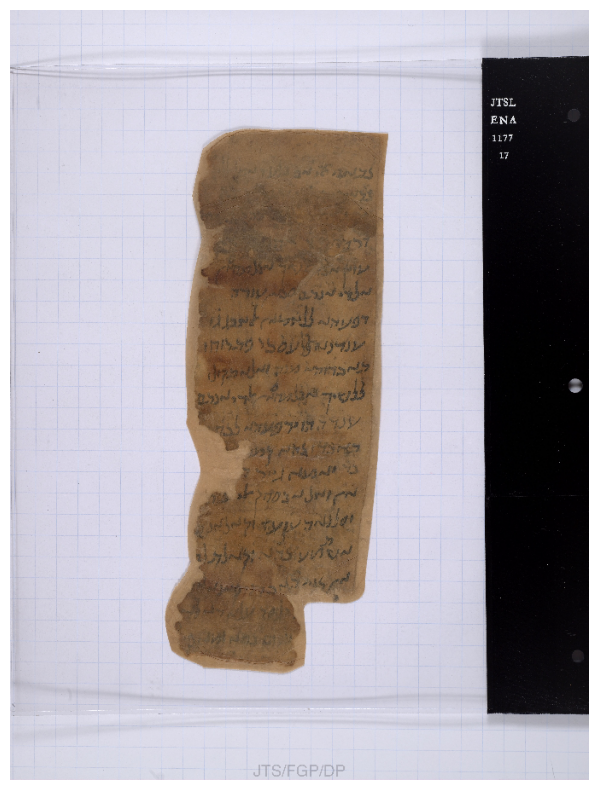

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(processed_image)
plt.axis("off")
plt.show()

In [8]:
def show_image_masks(image, masks):
    """
    Display an image overlaid with masks.

    This function displays a given image in a new figure with given masks overlaid on it.
    The masks are visualized using different colors with a set transparency level.

    Parameters
    ----------
    image : ndarray
        The base image to be displayed. This should be a numpy array of shape 
        (height, width, 3) and the values should be in the range [0, 1] for floats or [0, 255] for integers.
    masks : list
        A list of annotation dictionaries. Each dictionary should have a 'segmentation' key and 
        an 'area' key. The value of 'segmentation' should be a numpy array representing the mask 
        of the annotation, and the value of 'area' should be a float representing the area of the annotation.

    Returns
    -------
    None
    """
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_anns(masks, alpha=0.70)
    plt.axis("off")
    plt.show() 

In [9]:
# tuning settings
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=16,
    points_per_batch=256,
    pred_iou_thresh=0.98,
    stability_score_thresh=0.98,
    min_mask_region_area=128 * 128
)

In [10]:
masks = mask_generator.generate(processed_image)

In [19]:
masks[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 131747,
 'bbox': [182, 140, 259, 635],
 'predicted_iou': 1.0253205299377441,
 'point_coords': [[275.4375, 366.84375]],
 'stability_score': 0.9921121001243591,
 'crop_box': [0, 0, 678, 903]}

In [11]:
len(masks)

4

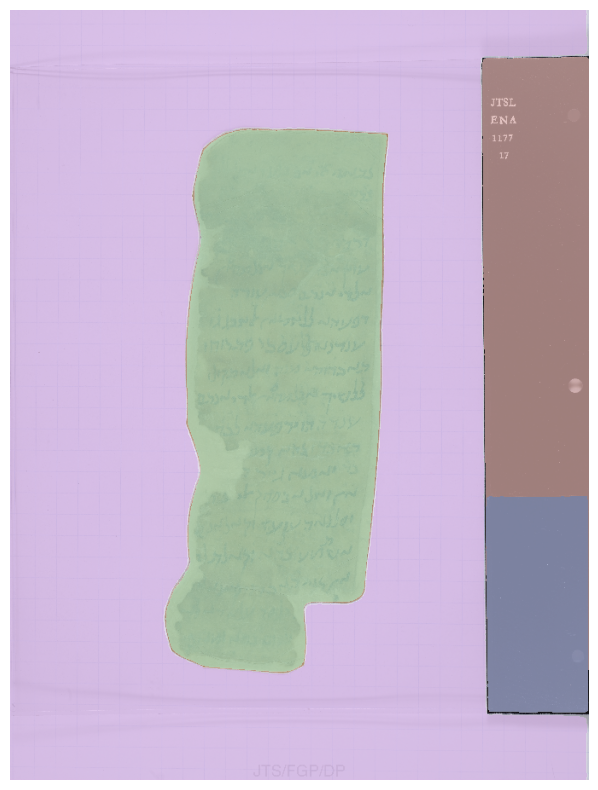

In [12]:
show_image_masks(image, masks)

In [13]:
def generate_and_show_masks_from_image_path(image_path, sam_mask_generator):
    """
    Generate and display masks for a given image using a 
    specified mask generator. 

    Parameters
    ----------
    image_path : str
        A string representing the path of the image file to be loaded.
    sam_mask_generator : object
        An instance of a mask generator class. 
        
    Returns
    -------
    None
    """
    image = load_and_resize_image(image_path)
    processed_image = preprocess_image(image)
    
    masks = sam_mask_generator.generate(processed_image)
    
    show_image_masks(image, masks)

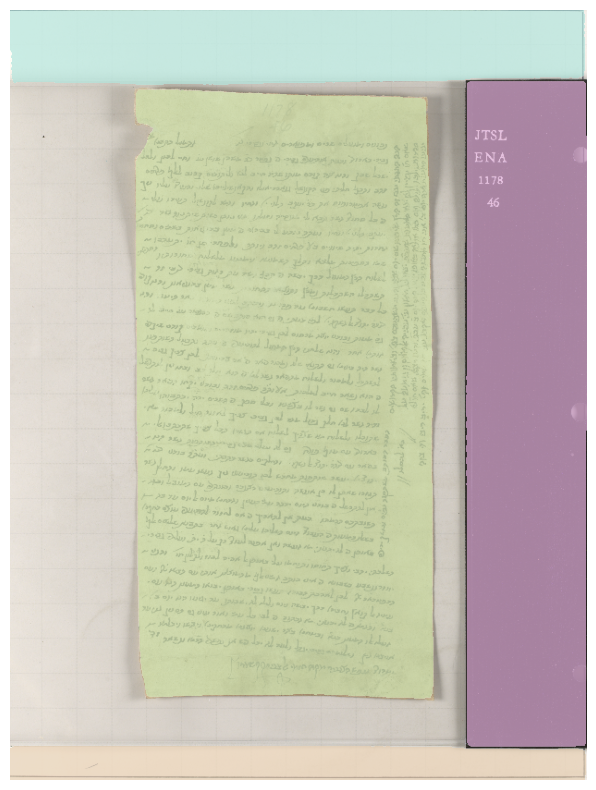

In [14]:
generate_and_show_masks_from_image_path("/projects/RUSTOW/htr_deskewing_image_dataset/needs_deskewing/ENA 1178/000046/ENA_1178_046_r.tif", mask_generator)    